In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/gan-171103/GAN_171103.py
/kaggle/input/creditcardfraud/creditcard.csv


# Importing Libraries

1. import psutil: This imports the psutil (Python System and Utilities) library, which is used to retrieve information on system utilization (CPU, memory, disks, network, sensors) and process management
2. import xgboost as xgb: Imports XGBoost, a popular library for gradient boosting algorithms
3. import pickle: Imports the pickle module, which is used for serializing and de-serializing Python object structures
4. import gc: Imports the garbage collector interface, which is used to manage the allocation and deallocation of memory

In [25]:
# Load libraries and check memory

import psutil ; print(list(psutil.virtual_memory())[0:2])

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import xgboost as xgb

import pickle

import gc
gc.collect()
print(list(psutil.virtual_memory())[0:2])

[33669922816, 31817093120]
[33669922816, 31817187328]


import GAN_171103: This line imports the module GAN_171103. This module is a custom script related to Generative Adversarial Networks (GANs)

In [26]:
import sys

sys.path.append('/kaggle/input/gan-171103')
import GAN_171103

In [27]:
import importlib
importlib.reload(GAN_171103) 
from GAN_171103 import *

The provided function, create_toy_spiral_df, is designed to generate a toy dataset that forms a spiral pattern, resembling a Swiss roll. This kind of dataset is often used in machine learning for testing algorithms, especially those used in visualization, dimensionality reduction, or clustering

In [28]:
# Function to create toy spiral dataset (looks like swiss roll)

def create_toy_spiral_df( n, seed=0):
    np.random.seed(seed)
    toy = np.array([ [ (i/10+1) * np.sin(i), -(i/10+1) * np.cos(i) ] for i in np.random.uniform(0,3*np.pi,size=n) ])
    toy = pd.DataFrame( toy, columns=[ ['v'+str(i+1) for i in range(2)] ])
    return toy


The function create_toy_df is designed to generate a toy dataset comprising multiple groups of normal distributions across a specified number of dimensions. It's a useful tool for creating synthetic datasets for machine learning experiments, particularly for testing clustering algorithms

In [29]:
# Function to create toy dataset of multiple groups of normal distributions in n dimensions

def create_toy_df( n, n_dim, n_classes, seed=0):
    toy = pd.DataFrame(columns=[ ['v'+str(i+1) for i in range(n_dim)] + ['Class'] ])
    toy_cols = toy.columns
    np.random.seed(seed)
    for class0 in range(n_classes):
        center0s = np.random.randint(-10,10,size=n_dim)/10
        var0s = np.random.randint(1,3,size=n_dim)/10
        temp = np.array([[class0]]*n)
        for dim0 in range(n_dim):
            temp = np.hstack( [np.random.normal(center0s[dim0],var0s[dim0],n).reshape(-1,1), temp] )
        toy = pd.concat([toy,pd.DataFrame(temp,columns=toy_cols)],axis=0).reset_index(drop=True)
    return toy

In [30]:
# Load the credit card data

# Original data available from:
# https://www.kaggle.com/dalpozz/creditcardfraud

data = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")
print(data.shape)
print(data.columns)
data.head(3)

(284807, 31)
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [31]:
# data columns will be all other columns except class

label_cols = ['Class']
data_cols = list(data.columns[ data.columns != 'Class' ])

print(data_cols)
print('# of data columns: ',len(data_cols))

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
# of data columns:  30


In [32]:
# 284315 normal transactions (class 0)
# 492 fraud transactions (class 1)

data.groupby('Class')['Class'].count()

Class
0    284315
1       492
Name: Class, dtype: int64

In [33]:
# Total nulls in dataset (sum over rows, then over columns)

data.isnull().sum().sum()

0

These lines of code are designed to identify and count duplicate rows in a DataFrame, distinguishing between different classes. This analysis is important, especially in datasets used for fraud detection or other classification tasks, as duplicate entries can skew the results of machine learning models. The data is classified into 2 categories, labeled as 'Normal' (Class 0) and 'Fraud' (Class 1)

In [34]:
normal_duplicates = sum( data.loc[ data.Class==0 ].duplicated() )
fraud_duplicates = sum( data.loc[ data.Class==1 ].duplicated() )
total_duplicates = normal_duplicates + fraud_duplicates

print( 'Normal duplicates', normal_duplicates )
print( 'Fraud duplicates', fraud_duplicates )
print( 'Total duplicates', total_duplicates )
print( 'Fraction duplicated', total_duplicates / len(data) )

Normal duplicates 1062
Fraud duplicates 19
Total duplicates 1081
Fraction duplicated 0.00379555277784605


The 'Time' feature originally represents the seconds elapsed since the first transaction in the dataset. The code modifies this feature to reflect the time of day (in hours) and then creates a histogram to compare the distribution of normal and fraud transactions over the course of a day. This analysis is valuable for understanding the time-of-day patterns in the dataset, particularly to see if fraudulent transactions show a different pattern compared to normal transactions

Last time value: 48.00


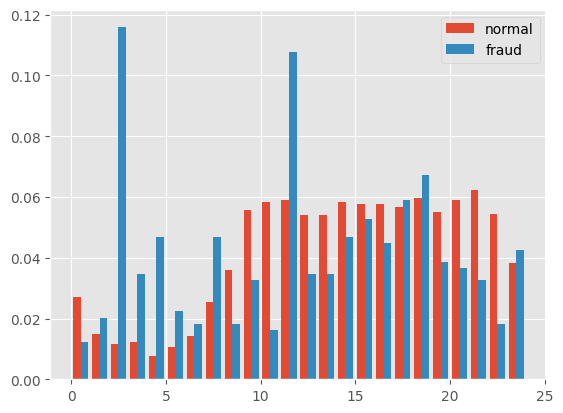

In [35]:
# 'Time' is seconds from first transaction in set
# 48 hours worth of data
# Let's convert time to time of day, in hours

print( 'Last time value: {:.2f}'.format( data['Time'].max() / 3600 ) )

data['Time'] = ( data['Time'].values / 3600 ) % 24

plt.hist( [ data.loc[ data['Class']==0, 'Time'], data.loc[ data['Class']==1, 'Time'] ],
         density=True, label=['normal','fraud'], bins=np.linspace(0,24,25))
plt.legend()
plt.show()

The x-axis represents the time of day in hours, and the y-axis represents the density of transactions.

From the histogram, it appears that transactions labeled as 'normal' and 'fraud' have different time distribution patterns:

The 'normal' transactions, represented in red, seem to be relatively uniform throughout the day with some fluctuations, which could be indicative of consistent transaction behavior over time.

The 'fraud' transactions, shown in blue, display distinct spikes at certain hours. This could suggest that fraudulent activities occur more frequently during specific periods of the day.

The density=True parameter indicates that the y-axis shows the proportion of transactions rather than the absolute count, which is useful for comparing the two classes when the number of samples might be imbalanced.

    Understanding Skewness:
        Skewness quantifies how much a distribution differs from a normal distribution in terms of asymmetry.
        If the skewness is close to 0, the distribution is nearly symmetrical.
        If the skewness is positive, the distribution is skewed to the right (or positively skewed), meaning that the right tail (larger values) is longer or fatter than the left tail. This implies that there is a larger number of high values.
        If the skewness is negative, the distribution is skewed to the left (or negatively skewed), meaning that the left tail (smaller values) is longer or fatter than the right tail. This indicates a larger number of low values.

    Applying skew() to DataFrame:
        data.skew(): This function computes the skewness of the data present in each column of the DataFrame data.
        The method returns a Series object with the skewness values for each column.

    Implication for the 'Amount' Column:
        You mentioned that the 'Amount' column is the most heavily skewed, besides the 'Class' column.
        High skewness in the 'Amount' column indicates that the distribution of transaction amounts is not symmetrical and leans towards higher or lower values.
        In a typical financial dataset, this could mean that most transactions are of relatively low value, with fewer high-value transactions (positive skew), or vice versa.

In [36]:
# several columns heavily skewed, 'Amount' the highest (besides Class)

data.skew()

Time      -0.499981
V1        -3.280667
V2        -4.624866
V3        -2.240155
V4         0.676292
V5        -2.425901
V6         1.826581
V7         2.553907
V8        -8.521944
V9         0.554680
V10        1.187141
V11        0.356506
V12       -2.278401
V13        0.065233
V14       -1.995176
V15       -0.308423
V16       -1.100966
V17       -3.844914
V18       -0.259880
V19        0.109192
V20       -2.037155
V21        3.592991
V22       -0.213258
V23       -5.875140
V24       -0.552499
V25       -0.415793
V26        0.576693
V27       -1.170209
V28       11.192091
Amount    16.977724
Class     23.997579
dtype: float64

The output displays the skewness values for each variable in a dataset, including 'Time', 'Amount', and variables V1 through V28. These values give an indication of the asymmetry in the distribution of each variable's values. Here's a summary of what the skewness values suggest:

    Time: The skewness is close to zero, indicating that the 'Time' variable is fairly symmetrically distributed across the dataset.

    V1-V28: These are likely to be features that have been transformed for privacy reasons in a dataset related to financial transactions or similar. The skewness of these variables varies widely. Some, like V8 and V23, are highly negatively skewed, suggesting a longer or fatter tail on the left side of the distribution. Others, such as V21, are positively skewed, indicating a longer or fatter tail on the right.

    Amount: With a skewness value of approximately 16.98, the 'Amount' variable is highly positively skewed. This indicates that there is a long tail on the right side of its distribution, suggesting that there are a number of transactions with amounts much larger than the average, which is typical in transactional data where most transactions are small and only a few are very large.

The code snippet provided is part of a data analysis process focusing on the 'Amount' column of a dataset, likely a financial transactions dataset. The comments and code together give information about the distribution of transaction amounts and specifically highlight the proportion of transactions that have an amount of 0

In [37]:
# Minimum 'Amount' is 0
# 0's account for 0.6% of the data set

print( data['Amount'].min() )
print( np.sum( data['Amount']==0 ) )
# print( np.sum( data['Amount']<0.01 ) )
print( np.sum( data['Amount']==0 ) / len(data) )

0.0
1825
0.006407848121710491


he line of code data['Amount'].mod(0.01).hist() is used to check whether all 'Amount' values in the DataFrame data are rounded to the nearest cent (hundredths place)

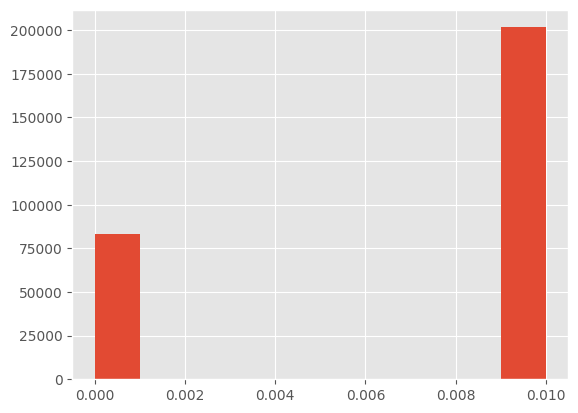

In [38]:
# Looks like all 'Amount' values are rounded to the hundredths (0.01) place
data['Amount'].mod(0.01).hist() ;

In the histogram, we observe two bars:

    The first bar is close to 0.00, which means that a large number of 'Amount' values have no remainder when divided by 0.01, suggesting these amounts are indeed rounded to the nearest cent.
    The second bar, at 0.01, is substantially taller, indicating an even greater number of 'Amount' values are exactly at the cent (0.01), with no remainder.

This pattern confirms that the 'Amount' values are rounded to the nearest cent, as expected from the code snippet you provided earlier. The tall bar at 0.01 is likely due to the fact that the modulus operation returns exactly 0.01 for amounts that are precisely a multiple of 0.01, which would be the majority if all amounts are rounded to the nearest cent. The presence of a smaller bar close to 0.00 might indicate that there are also a number of values that are just slightly over a cent multiple

In [39]:
# Some values are much more frequent than others
# 0.00 comes in 12th in the list

print( data.Amount.value_counts().head(15) )

Amount
1.00     13688
1.98      6044
0.89      4872
9.99      4747
15.00     3280
0.76      2998
10.00     2950
1.29      2892
1.79      2623
0.99      2304
20.00     2002
0.00      1825
8.99      1811
11.50     1741
4.49      1579
Name: count, dtype: int64


From the output, it is evident that:

    The amount of $1.00 is the most common transaction amount, occurring 13,688 times.
    The next most common amounts are $1.98 and $0.89, with 6,044 and 4,872 occurrences respectively.
    The amount of $0.00 is the 12th most common, with 1,825 occurrences.

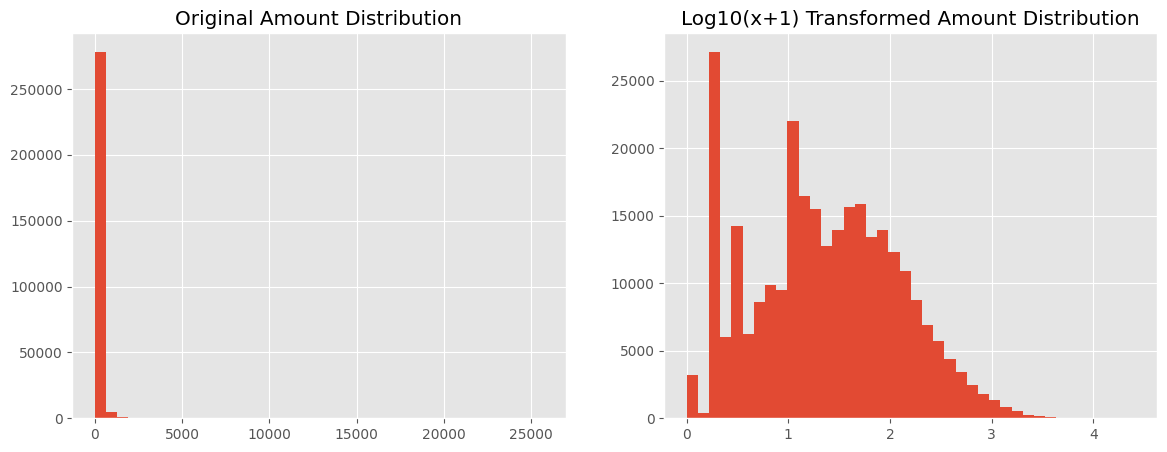

In [40]:
# Log transform amount values to give more normal distribution

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.hist(data['Amount'], bins=40)
plt.title('Original Amount Distribution')

plt.subplot(1,2,2)
d0 = np.log10( data['Amount'].values + 1 )
# d0 = np.log1p( data['Amount'].values ) / np.log(10)
plt.hist( d0, bins=40 )
plt.title('Log10(x+1) Transformed Amount Distribution')
plt.show()

    Left Histogram (Original Amount Distribution):
        This histogram shows the original distribution of the 'Amount' data. The x-axis represents the transaction amounts, and the y-axis represents the frequency of transactions.
        The distribution is highly skewed to the right, with a large peak at the lower end of the scale, indicating that most transactions are of lower value, and a long tail extending towards higher transaction amounts, which occur less frequently.

    Right Histogram (Log10(x+1) Transformed Amount Distribution):
        This histogram shows the distribution of the 'Amount' data after applying a log transformation, specifically log10(x+1) to each transaction amount.
        The x-axis represents the log-transformed values, and the y-axis represents the frequency of transactions.
        The log transformation is a common technique used to reduce right skewness in the data. It can help reveal patterns that are not visible in the original data and can make the dataset more suitable for algorithms that assume a normal distribution.
        The transformed distribution appears more bell-shaped compared to the original, which is a characteristic of a normal distribution, though it is not perfectly symmetrical.

In [41]:
# Use log transformed data

data['Amount'] = d0

The code calculates the 0.1 and 99.9 percentiles for each feature (column) in data_cols. These percentiles are used to define the boundaries of the data that will be included in the centering and scaling process, effectively trimming the most extreme 0.2% of the data to mitigate the influence of outliers.

In [42]:
# Center and scale all data, only using the middle 99.8%, so outliers don't pull too much.
# First generate the percentile data for each feature

# Calculate the percentiles
percentiles = pd.DataFrame(
    np.array([np.percentile(data[i], [0.1, 99.9]) for i in data_cols]).T,
    columns=data_cols, index=['min', 'max']
)

# Calculate the means for values within the percentile range
percentile_means = [
    np.mean(data.loc[
        (data[i] > percentiles.loc['min', i]) & (data[i] < percentiles.loc['max', i]), i
    ]) for i in data_cols
]

# Calculate the standard deviations for values within the percentile range
percentile_stds = [
    np.std(data.loc[
        (data[i] > percentiles.loc['min', i]) & (data[i] < percentiles.loc['max', i]), i
    ]) for i in data_cols
]

# Append means and standard deviations to the percentiles DataFrame
percentiles = pd.concat([
    percentiles,
    pd.DataFrame([percentile_means], columns=data_cols, index=['mean']),
    pd.DataFrame([percentile_stds], columns=data_cols, index=['stdev'])
])

percentiles

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
min,0.025833,-16.044343,-15.126221,-9.870326,-4.163262,-9.408512,-5.290163,-9.365179,-13.102174,-3.305247,...,-6.621889,-5.490204,-3.119845,-5.452756,-2.001248,-2.403083,-1.276676,-3.823857,-2.629030,0.000000
max,23.965278,2.344685,7.852129,3.387393,6.235906,8.074611,6.164944,7.972745,6.135087,5.960836,...,5.809376,7.879007,2.260348,4.759942,1.246819,1.873743,2.251097,2.607462,2.095818,3.477266
mean,14.543063,0.020195,0.012756,0.011923,-0.003827,0.002532,-0.000677,0.001153,0.011022,-0.002363,...,0.002214,-0.002930,0.001083,0.002081,0.000089,0.000504,-0.001117,0.001314,-0.000914,1.375513
stdev,5.827070,1.814661,1.429787,1.419404,1.383725,1.208541,1.263637,1.018486,0.956445,1.064801,...,0.595668,0.550113,0.704365,0.433626,0.596816,0.505554,0.474011,0.330955,0.223416,0.710045


The min and max rows correspond to the 0.1 and 99.9 percentiles, respectively, which indicate the range within which the central 99.8% of the data for each feature falls. The mean and standard deviation (stdev) have been computed using only the data within this percentile range.

This table is useful for understanding the central tendency and variability of your data after trimming the most extreme outliers. This trimmed data can be used for further analysis or as input to machine learning algorithms that assume data is normally distributed and not heavily influenced by outliers.

Based on these statistics, you can now standardize the dataset so that each feature will have a mean of 0 and a standard deviation of 1, only considering the central 99.8% of the data

In [43]:
# Center and scale the data using the percentile data we just generated

data[data_cols] = ( data[data_cols] - percentiles.loc[ 'mean', data_cols ] ) / percentiles.loc[ 'stdev', data_cols ]

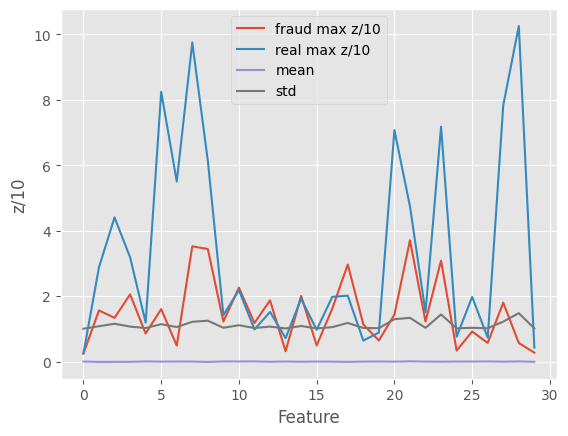

In [44]:
# There are outliers, 50-100 stdevs away from mean in several columns

plot_cols = data_cols
# plt.plot( np.log10( data[ plot_cols ].abs().max().values ) )
# plt.plot( data[ plot_cols ].abs().max().values / data[ plot_cols ].std().values / 10, label='max z/10' )
plt.plot( data.loc[ data.Class==1, plot_cols ].abs().max().values / data[ plot_cols ].std().values / 10, label='fraud max z/10' )
plt.plot( data.loc[ data.Class==0, plot_cols ].abs().max().values / data[ plot_cols ].std().values / 10, label='real max z/10' )
plt.plot( data[ plot_cols ].mean().values, label='mean' )
# plt.plot( data[ plot_cols ].abs().mean().values, label='abs mean' )
plt.plot( data[ plot_cols ].std().values, label='std' )
plt.xlabel('Feature')
plt.ylabel('z/10')
plt.legend() ; 

    The plot shows lines representing the mean and standard deviation for each feature.
    There are also lines representing the maximum z-scores (scaled down) for both fraud and normal transactions (as indicated by the legend).
    The peaks in the 'fraud max z/10' and 'real max z/10' lines indicate features where the maximum values are many standard deviations away from the mean, suggesting the presence of outliers.
    
    The peaks in the 'fraud max z/10' and 'real max z/10' lines suggest that certain features have values that are extreme outliers, being many standard deviations away from the mean. These might be particularly interesting in the context of fraud detection, as they could represent anomalous behavior that is indicative of fraudulent activity

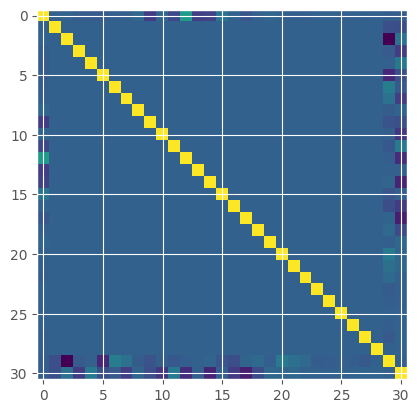

In [45]:
# Check Correlations
# Note no correlations among PCA transformed columns, as expected
corr0 = data.corr()
plt.imshow(corr0) ;

    A value of 1 implies a perfect positive correlation: as one variable increases, the other variable increases at a proportional rate.
    A value of -1 implies a perfect negative correlation: as one variable increases, the other variable decreases at a proportional rate.
    A value of 0 implies no correlation: the variables do not have a linear relationship.

In the heatmap:

    The diagonal, highlighted in yellow, represents the correlation of each variable with itself, which is always 1.
    The squares in blue indicate very low or no correlation between different variables.
    
    The columns have been previously transformed using Principal Component Analysis (PCA). One of the outcomes of PCA is that it orthogonalizes the components, meaning that it removes correlation between them, which is confirmed by the blue off-diagonal elements in the heatmap.

This code generates a series of histograms, one for each feature in the data_cols list, comparing the distributions of two classes labeled 'normal' and 'fraud'. It's meant to visualize how the data for each feature is distributed within each class, which can be particularly useful for feature selection or to gain insights into which features may be good predictors for classification purposes

/tmp/ipykernel_42/448158159.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot2grid((rows, columns), (i // columns, i % columns))


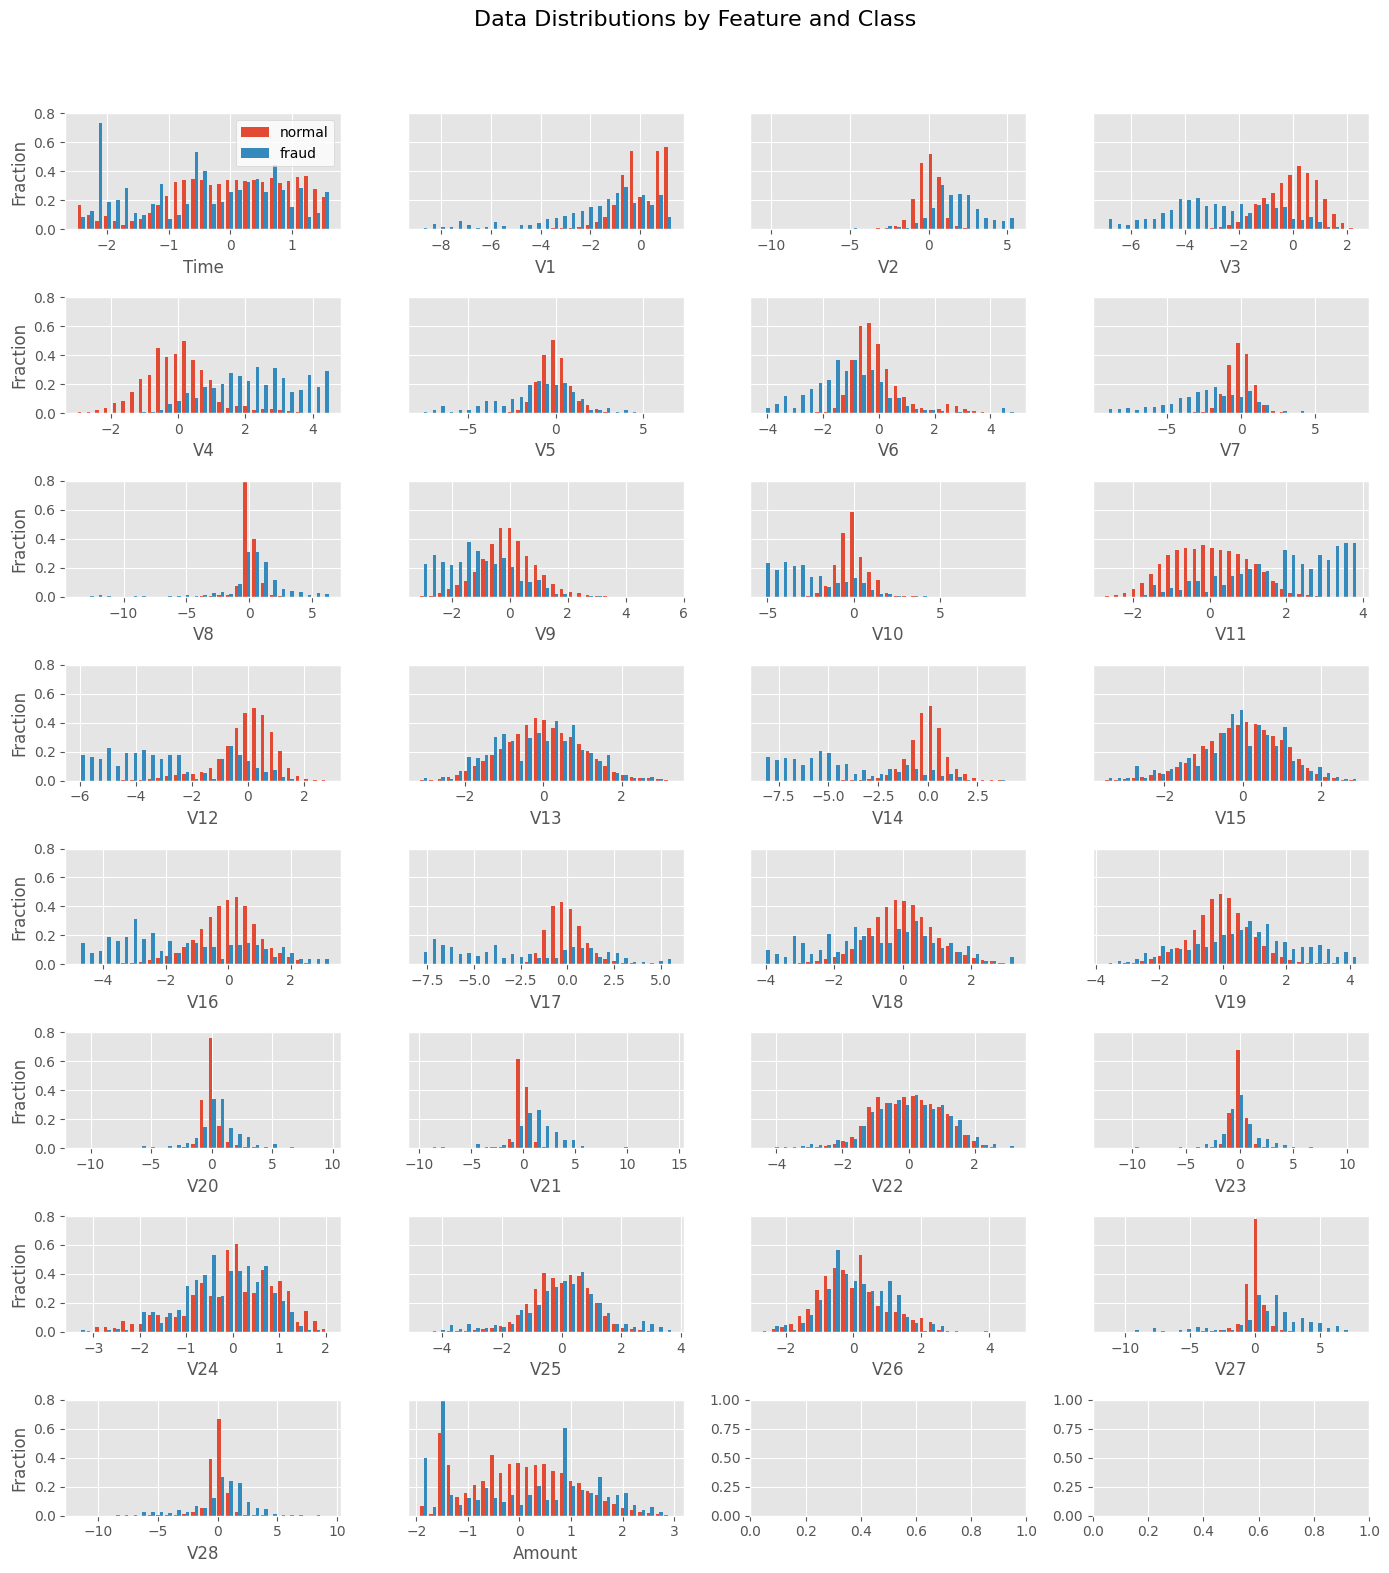

In [46]:
# Plot the data by each feature

columns = 4
rows = int(np.ceil(len(data_cols) / columns))
f, fig = plt.subplots(figsize=(columns * 3.5, rows * 2), nrows=rows, ncols=columns)

f.suptitle('Data Distributions by Feature and Class', size=16)

for i, col in enumerate(data_cols[:]):
    ax = plt.subplot2grid((rows, columns), (i // columns, i % columns))
    ax.hist([data.loc[data.Class == 0, col], data.loc[data.Class == 1, col]], label=['normal', 'fraud'],
            bins=np.linspace(np.percentile(data[col], 0.1), np.percentile(data[col], 99.9), 30),
            density=True)
    ax.set_xlabel(col, size=12)
    ax.set_ylim([0, 0.8])
    ax.tick_params(axis='both', labelsize=10)
    if i == 0:
        legend = ax.legend()
        legend.get_frame().set_facecolor('white')
    if i % 4 != 0:
        ax.tick_params(axis='y', which='both', left=False, labelleft=False)
    else:
        ax.set_ylabel('Fraction', size=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # xmin, ymin, xmax, ymax
# plt.savefig('plots/Engineered_Data_Distributions.png')
plt.show()

These histograms compare the distribution of values for two different classes, typically labeled 'normal' and 'fraud', which are represented by red and blue bars, respectively.

Each histogram plots the density (fraction) of observations on the y-axis against the feature values on the x-axis. The density aspect ensures that the area under the bars adds up to 1, making it easier to compare the distributions between the two classes despite any differences in sample size.

From these histograms, one can infer which features show significant differences in distribution between normal and fraud classes. Features with distinct differences in the histograms could be more informative for a predictive model aimed at distinguishing between the classes.

The histograms also show that for many features, the 'fraud' class has a different distribution compared to the 'normal' class, which may indicate these features are good candidates for identifying fraudulent behavior. Some features show a high density of fraud cases at different intervals than normal cases, which can be an indicator of fraudulent activity patterns captured by the data.

In [47]:
# define the columns we want to test on, in case we want to use less than the full set

test_cols = data.columns

# test_cols = data.columns[ data.columns != 'Amount' ]

print(len(test_cols))
print(test_cols)

31
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


XGBoost allows for the use of custom objective and evaluation metrics that can be passed to the model during training. This is particularly useful when you want to optimize or track performance metrics that are not included by default in XGBoost's suite of metrics

These functions can be passed to XGBoost during training to evaluate model performance on the training data at each iteration. The XGBoost model will output the values of these metrics, allowing you to monitor the model's performance according to these specific measures.

In [48]:
# Define some custom metric functions for use with the xgboost algorithm
# https://github.com/dmlc/xgboost/blob/master/demo/guide-python/custom_objective.py

from sklearn.metrics import recall_score, precision_score, roc_auc_score

def recall(preds, dtrain):
    labels = dtrain.get_label()
    return 'recall',  recall_score(labels, np.round(preds), average='macro')

def precision(preds, dtrain):
    labels = dtrain.get_label()
    return 'precision',  precision_score(labels, np.round(preds))

def roc_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'roc_auc',  roc_auc_score(labels, preds)

This code sets up training and testing datasets for a machine learning model, likely for a binary classification task where the target variable Class indicates if an example is 'real' (class 0) or 'fraud' (class 1). The script is preparing the data for a supervised learning task using XGBoost, and the construction of dtrain and dtest

In [49]:
# Set up the test and train sets

np.random.seed(0)

n_real = np.sum(data.Class==0) # 200000
n_test = np.sum(data.Class==1) # 492
train_fraction = 0.7
fn_real = int(n_real * train_fraction)
fn_test = int(n_test * train_fraction)

real_samples = data.loc[ data.Class==0, test_cols].sample(n_real, replace=False).reset_index(drop=True)
test_samples = data.loc[ data.Class==1, test_cols].sample(n_test, replace=False).reset_index(drop=True)

train_df = pd.concat([real_samples[:fn_real],test_samples[:fn_test]],axis=0,ignore_index=True).reset_index(drop=True)
# train_df = pd.concat([real_samples[:fn_test],test_samples[:fn_test]],axis=0,ignore_index=True).reset_index(drop=True)

test_df = pd.concat([real_samples[fn_real:],test_samples[fn_test:]],axis=0,ignore_index=True).reset_index(drop=True)
print( 'classes 0, 1: ', n_real, n_test )
print( 'train, test: ', len(train_df), len(test_df) )

X_col = test_df.columns[:-1].tolist()  # Convert to list of strings
y_col = test_df.columns[-1]            # This is already a string, no conversion needed

dtrain = xgb.DMatrix(train_df[X_col], label=train_df[y_col], feature_names=X_col)
dtest = xgb.DMatrix(test_df[X_col], label=test_df[y_col], feature_names=X_col)


classes 0, 1:  284315 492
train, test:  199364 85443


The code snippet is setting up and running an XGBoost training session for a binary classification problem, with the objective to maximize the recall on the test set.

This snippet effectively demonstrates how to customize the training of an XGBoost model with specific goals in mind, such as optimizing for recall

In [50]:
# Run the xgboost algorithm, maximize recall on the test set

results_dict = {}

xgb_params = {
#     'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc', # auc, error
#     'tree_method': 'hist'
#     'grow_policy': 'lossguide' # depthwise, lossguide
}

xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=100, 
                     verbose_eval=False,
                     early_stopping_rounds=20, 
                     evals=[(dtrain,'train'),(dtest,'test')],
                     evals_result = results_dict,              
                     feval = recall, maximize=True
#                      feval = roc_auc, maximize=True
                    )

y_pred = xgb_test.predict(dtest)
y_true = test_df['Class'].values
print( 'best iteration: ', xgb_test.best_iteration )
print( recall( y_pred, dtest ) )
print( precision( y_pred, dtest ) )
print( roc_auc( y_pred, dtest ) )
# print( 'Accuracy: {:.3f}'.format(SimpleAccuracy(y_pred, y_true)) )
SimpleMetrics( np.round(y_pred), y_true)

/opt/conda/lib/python3.10/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMet

best iteration:  2
('recall', 0.8681904851683269)
('precision', 0.923728813559322)
('roc_auc', 0.9771956389826721)
Confusion Matrix


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Pred 0,Pred 1
True 0,85286,9
True 1,39,109


Accuracy : 0.9994382219725431


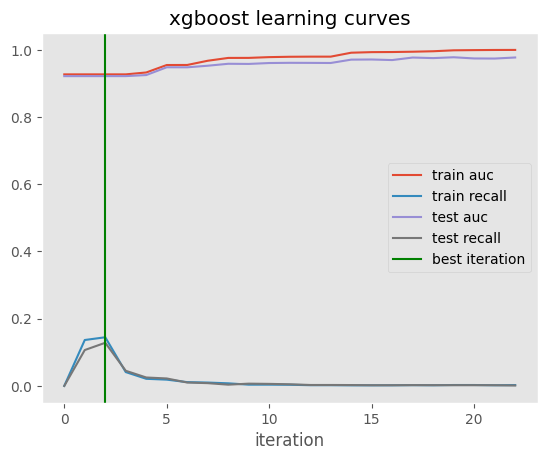

In [51]:
# Let's look at how the metrics changed on the train and test sets as more trees were added

for i in results_dict:
    for err in results_dict[i]:
        plt.plot(results_dict[i][err], label=i+' '+err)   
plt.axvline(xgb_test.best_iteration, c='green', label='best iteration')
plt.xlabel('iteration')
# plt.ylabel(err)
plt.title('xgboost learning curves')
plt.legend()
plt.grid() ;

    Train AUC: The area under the ROC curve (AUC) for the training set. A higher AUC indicates better model performance.
    Train Recall: The recall score for the training set. High recall indicates that the model is capturing a high proportion of positive cases.
    Test AUC: The AUC for the testing set. This is a measure of the model's ability to generalize to unseen data.
    Test Recall: The recall score for the testing set. This shows how well the model is generalizing in terms of capturing positive cases in the unseen data.
    Best Iteration: A vertical line indicating the best iteration of the model, which is the point during training where the model achieved the best performance on the test set before it began to overfit.
    
    The convergence of train and test curves at high AUC and recall values suggests a good balance between the model's ability to learn and generalize,
    
    The vertical line for the best iteration indicates the optimal stopping point chosen by early stopping, which helps prevent overfitting by not allowing the model to continue training past the point where performance on the test set is no longer improving.

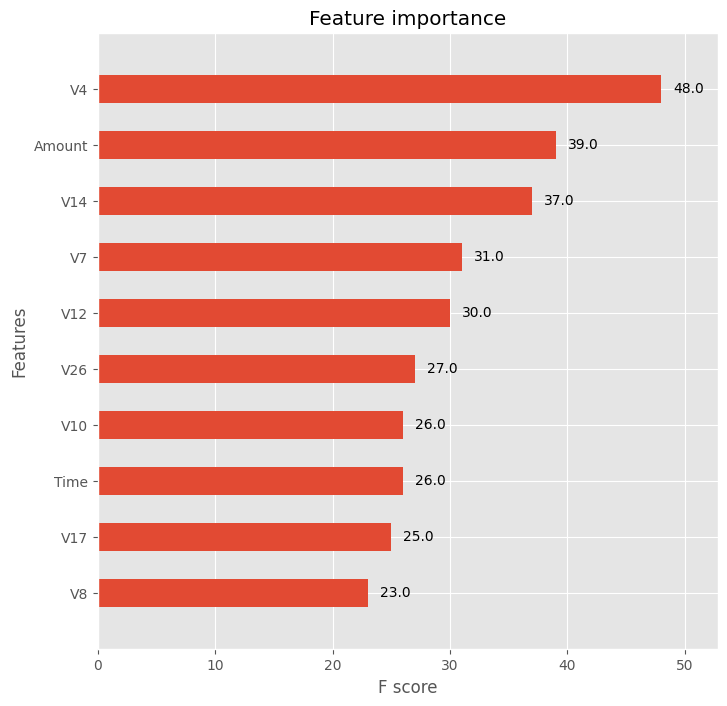

In [52]:
# Plot feature importances

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
xgb.plot_importance(xgb_test, max_num_features=10, height=0.5, ax=ax);

In the chart:

    Each bar represents a feature from the dataset, and the length of the bar indicates the feature's importance as determined by the XGBoost model. The importance is usually measured by the "F score," which, in the context of XGBoost, often refers to the number of times a feature is used to split the data across all trees (also known as "gain" or "weight").
    The features are listed in descending order of importance, with the top feature having the highest F score.
    
    The features V4, Amount, V14, V7, V12, V26, V10, Time, V17, and V8 appear to be the most important for the model, with V4 being the most significant. This information is crucial because it helps in understanding which features contribute most to the model's decision-making process and could be useful for feature selection in future iterations of model development
    
    For example, if some features are not available or costly to collect in practice, one might focus on the most important features that contribute to the model's predictive power.

In [53]:
# Generate list of features sorted by importance in detecting fraud
# https://stackoverflow.com/questions/613183/sort-a-python-dictionary-by-value

import operator
x = xgb_test.get_fscore()
sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)

# print( 'Top eight features for fraud detection: ', [ i[0] for i in sorted_x[:8] ] )

sorted_cols = [i[0] for i in sorted_x] + ['Class']
print( sorted_cols )

['V4', 'Amount', 'V14', 'V7', 'V12', 'V26', 'Time', 'V10', 'V17', 'V8', 'V19', 'V3', 'V16', 'V28', 'V24', 'V11', 'V20', 'V25', 'V22', 'V13', 'V18', 'V15', 'V21', 'V23', 'V27', 'V2', 'V6', 'V9', 'V1', 'V5', 'Class']


/tmp/ipykernel_42/3104623107.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


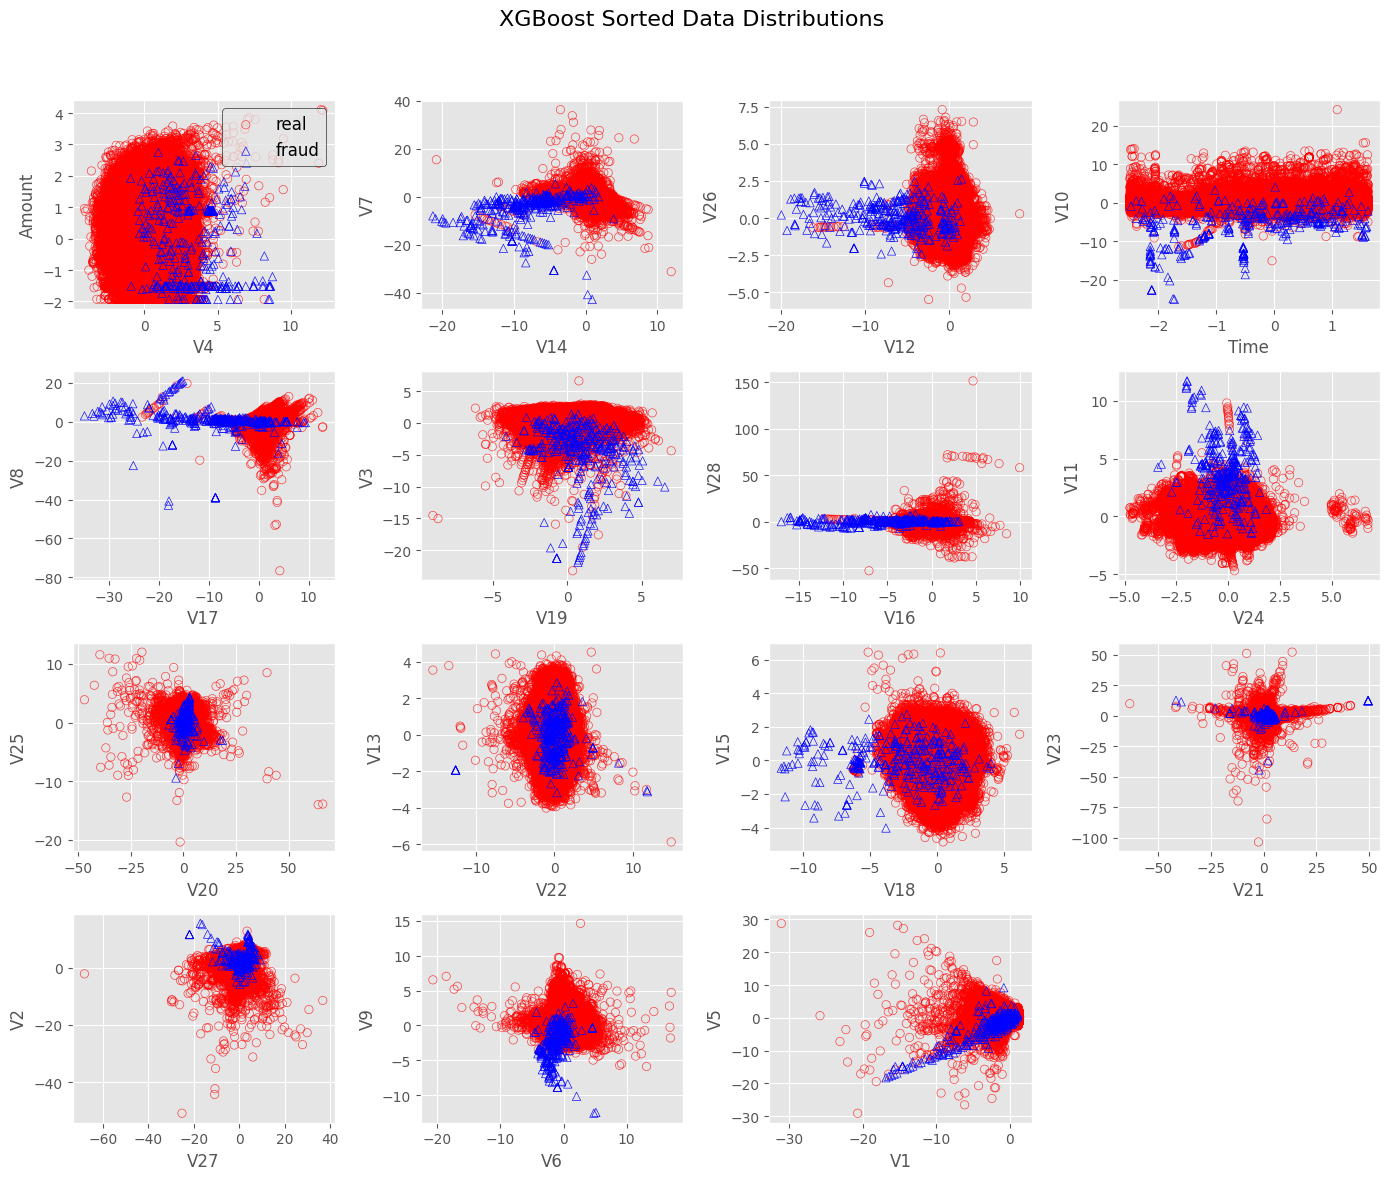

In [54]:
# Plot all of the training data with paired features sorted by importance
# This takes a while

colors = ['red','blue']
markers = ['o','^']
labels = ['real','fraud']
alphas = [0.7, 0.9]

columns = 4
rows = int( np.ceil( len(data_cols) / columns / 2 ) )
plt.figure( figsize=(columns*3.5, rows*3) )
plt.suptitle('XGBoost Sorted Data Distributions ', size=16)

train = train_df.copy()

for i in range( int(np.floor(len(sorted_x)/2)) )[:]:
    col1, col2 = sorted_x[i*2][0], sorted_x[i*2+1][0]
#     print(i,col1,col2)
    
    plt.subplot(rows,columns,i+1)  
    for group, color, marker, label, alpha in zip( train.groupby('Class'), colors, markers, labels, alphas ):
        plt.scatter( group[1][col1], group[1][col2], 
                         label=label, marker=marker, alpha=alpha,
                         edgecolors=color, facecolors='none' )         
    plt.xlabel(col1, size=12)
    plt.ylabel(col2, size=12)
    plt.tick_params(axis='both', labelsize=10)
    if i == 0: plt.legend(fontsize=12, edgecolor='black')

plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
# plt.savefig('plots/XGB_Sorted_Data_Distributions.png')
plt.show()

The images you've provided show scatter plots for pairs of features from a dataset. The points are color-coded and marked differently to represent two classes: 'real' (commonly the majority class) and 'fraud' (commonly the minority class). This type of visualization is useful for examining the relationship between pairs of features and how well they might separate the two classes.

In the scatter plots:

    The red circles ('o') represent the 'real' class.
    The blue triangles ('^') represent the 'fraud' class.
    The opacity (alpha) of the points may vary, with fraud points typically being more opaque to stand out against a larger number of real transactions.

These plots allow you to visually assess which feature combinations might be most effective at distinguishing between the two classes. Features that show clear separation between red and blue points could be particularly useful for building a predictive model.

For example, if the 'fraud' points cluster in a region of the plot that is distinct from where the 'real' points cluster, the corresponding features could be strong predictors for the model. Conversely, if the points overlap significantly, it may be harder for a model to distinguish between the classes based solely on those features.

These visual insights can guide feature selection and engineering. For instance, you might choose to include features in your model that show clear separations in these scatter plots. Additionally, such plots can highlight the need for further preprocessing steps, like scaling or transforming features to improve the model's ability to learn from them.

The plots also help in understanding the nature of the data and any potential data quality issues, such as outliers or unusual clusters, which might need to be addressed

This code snippet is designed to investigate how varying the ratio of 'normal' (class 0) to 'fraud' (class 1) samples in the training dataset affects the performance of an XGBoost model in terms of recall and ROC-AUC. Cross-validation is used to ensure the reliability of the results.

In [55]:
# Lets look at the effect of the ratio of normal:fraud data in the dataset on recall and roc_auc
# We'll use cross validation to see if differences are significant


np.random.seed(0)

n_real = np.sum(data.Class==0) # 200000
n_test = np.sum(data.Class==1) # 492
real_samples = data.loc[ data.Class==0, test_cols].sample(n_real, replace=False).reset_index(drop=True)
test_samples = data.loc[ data.Class==1, test_cols].sample(n_test, replace=False).reset_index(drop=True)
X_col = data.columns[:-1]
y_col = data.columns[-1]

test_data=[]

# for i in [1]:
# for i in [0.1,0.5,1,2,10]:
for i in np.logspace(-1,2,8):
    print(i)
    train_df = pd.concat([real_samples[:int(n_test*i)],test_samples[:n_test]],axis=0,ignore_index=True).reset_index(drop=True)
    dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col.tolist())
    results = xgb.cv(xgb_params, dtrain, 
                     nfold=5, num_boost_round=100, early_stopping_rounds=10, seed=0,
                     feval=recall)
    test_data.append(list([i]) + list(results.tail(1).index) + list(results.tail(1).values[0]))
    
test_data = pd.DataFrame(test_data, columns=list(['ratio','best'])+list(results.columns))
test_data

0.1


/opt/conda/lib/python3.10/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMet

0.2682695795279726


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined 

0.7196856730011519


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined 

1.9306977288832496


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined 

5.17947467923121


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined 

13.894954943731374


/opt/conda/lib/python3.10/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMet

37.27593720314938


/opt/conda/lib/python3.10/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMet

100.0


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined 

,ratio,best,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std,train-recall-mean,train-recall-std,test-recall-mean,test-recall-std
0,0.100000,20,1.000000,0.000000,0.985684,0.006767,0.000163,0.000156,0.008695,0.006471
1,0.268270,47,1.000000,0.000000,0.983464,0.010726,0.000000,0.000000,0.002258,0.001494
2,0.719686,69,1.000000,0.000000,0.981981,0.004483,0.000000,0.000000,0.002657,0.001264
3,1.930698,52,1.000000,0.000000,0.978679,0.011218,0.000000,0.000000,0.001140,0.000594
4,5.179475,0,0.969140,0.005684,0.947807,0.007799,0.000098,0.000091,0.000494,0.000767
5,13.894955,0,0.970644,0.003612,0.960806,0.016000,0.000073,0.000055,0.000146,0.000214
6,37.275937,0,0.966095,0.004917,0.952883,0.012780,0.000058,0.000032,0.000095,0.000070
7,100.000000,0,0.949834,0.006274,0.940047,0.029786,0.000049,0.000014,0.000086,0.000052


The DataFrame seems to include the following columns:

    ratio: The ratio of normal to fraud data used in the training set.
    best: The number of boosting rounds after which the best performance was achieved before early stopping kicked in.
    train-auc-mean and train-auc-std: The mean and standard deviation of the AUC scores on the training data across the cross-validation folds.
    test-auc-mean and test-auc-std: The mean and standard deviation of the AUC scores on the test data.
    train-recall-mean and train-recall-std: The mean and standard deviation of the recall scores on the training data.
    test-recall-mean and test-recall-std: The mean and standard deviation of the recall scores on the test data.

    The AUC scores on the training set (train-auc-mean) are consistently high across all ratios, close to 1.00, which may indicate good fit on the training data.
    The AUC scores on the test set (test-auc-mean) are slightly lower than the training AUC scores, which is typical due to the model being exposed to unseen data. However, they still indicate strong model performance.
    The recall scores on the test set (test-recall-mean) vary with different ratios, which suggests that the class balance in the training set does influence the model's ability to correctly identify positive (fraud) cases.

The table can be used to find the optimal balance between precision and recall for the model by comparing these metrics across different class ratios. This can inform decisions about how to handle class imbalance in the dataset, such as through resampling techniques or by adjusting the decision threshold of the classifier.

For a real-world application like fraud detection, it is crucial to achieve a balance where the recall is high (to catch as many fraudulent cases as possible) without sacrificing too much precision (to avoid too many false positives). The optimal ratio would be one that maximizes the desired performance metric, which could be recall, precision, AUC, or a combination of these, depending on the specific business objectives and the costs associated with false positives and false negatives

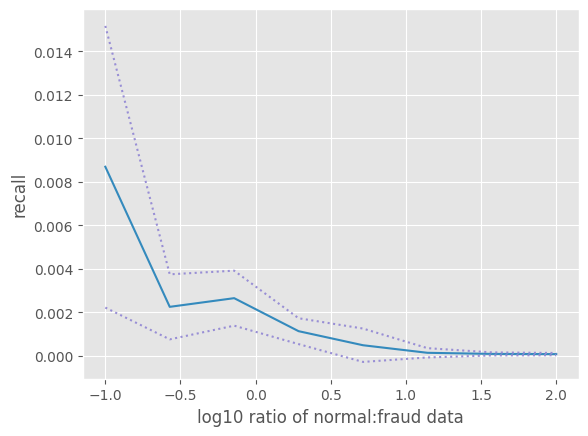

In [56]:
# Recall decreases as more normal data is added

# metric = 'auc'
metric = 'recall'
# xs = test_data['ratio'].values
xs = np.log10(test_data['ratio'].values)
ys = test_data['test-'+metric+'-mean'].values
stds = test_data['test-'+metric+'-std'].values
plt.plot(xs,ys,c='C1')
plt.plot(xs,ys+stds,linestyle=':',c='C2')
plt.plot(xs,ys-stds,linestyle=':',c='C2')
plt.xlabel('log10 ratio of normal:fraud data')
plt.ylabel(metric)
# plt.ylim([0.96,1.01])
plt.show()

The code snippet included in the image suggests that the plot is generated to observe the effect of varying the class balance on model performance, particularly focusing on recall as the evaluation metric

The resulting plot shows a trend line indicating how the recall metric changes as the ratio of normal-to-fraud data varies. The error bars (dotted lines) represent the variability or uncertainty in the recall metric due to the inherent variability in the cross-validation process.

From the trend visible in the plot, we might infer that recall tends to decrease as the ratio of normal-to-fraud data increases, which is a common phenomenon in imbalanced datasets. As the amount of normal data increases relative to fraud data, the model may become biased towards predicting the majority class, resulting in a lower ability to correctly identify fraud cases (lower recall).

The plot helps in determining the optimal class balance for training the model, which is crucial for applications like fraud detection, where failing to detect a fraudulent case (low recall) can be very costly. The goal would be to choose a ratio that maintains high recall without compromising other important metrics like precision or AUC

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE
import xgboost as xgb

In [58]:
# Assuming 'data' is your DataFrame and 'Class' is the target column
# Set up training set to consist of only fraud data
train = data[data['Class'] == 1].copy()

# Display class distribution
print(train['Class'].value_counts())

Class
1    492
Name: count, dtype: int64


In [59]:
# Prepare data for clustering
label_cols = ['Class']
data_cols = [col for col in train.columns if col not in label_cols]
train_no_label = train[data_cols]

# Create TSNE projections
projections = [TSNE(random_state=i).fit_transform(train_no_label) for i in range(3)]

# Define clustering algorithms
algorithms = [
    ['KMeans', KMeans(n_clusters=2, random_state=0)],
    ['Agglomerative', AgglomerativeClustering(n_clusters=3)]
]

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


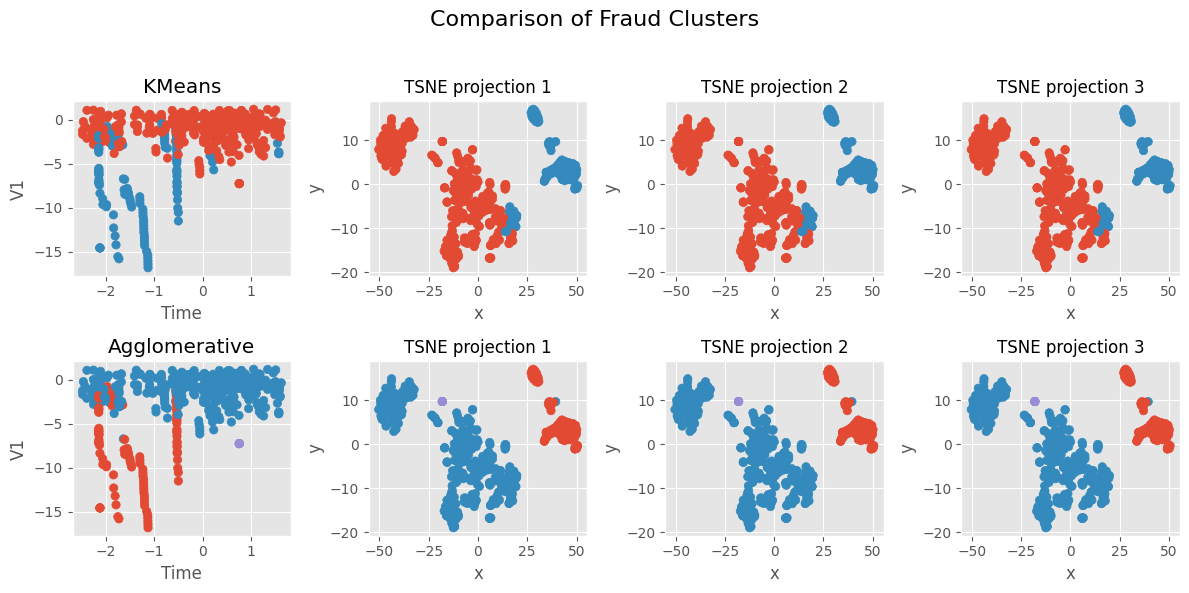

In [60]:
# Apply clustering and visualize
rows = len(algorithms)
columns = 4
plt.figure(figsize=(columns*3, rows*3))

for i, (name, algorithm) in enumerate(algorithms):
    labels = algorithm.fit_predict(train_no_label)
    colors = np.clip(labels, -1, 9)
    colors = ['C' + str(i) if i > -1 else 'black' for i in colors]

    plt.subplot(rows, columns, i * columns + 1)
    plt.scatter(train_no_label[data_cols[0]], train_no_label[data_cols[1]], c=colors)
    plt.xlabel(data_cols[0]), plt.ylabel(data_cols[1])
    plt.title(name)

    for j in range(3):
        plt.subplot(rows, columns, i * columns + 1 + j + 1)
        plt.scatter(*projections[j].T, c=colors)
        plt.xlabel('x'), plt.ylabel('y')
        plt.title('TSNE projection ' + str(j + 1), size=12)

plt.suptitle('Comparison of Fraud Clusters', size=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

he scatter plots also show data points projected onto two-dimensional space using t-SNE (t-distributed Stochastic Neighbor Embedding), which is a technique for dimensionality reduction and is particularly well-suited for the visualization of high-dimensional datasets.

In each row of the image, the leftmost plot likely shows the clustering result in the original feature space (with 'Time' and 'V1' as the axes for the KMeans example, and 'V1' for the Agglomerative example). The remaining three plots in each row show the clusters in three different t-SNE projections.

The points are color-coded, typically with red indicating one cluster and blue indicating another, which may correspond to the real and fraud classes, or to different clusters found by the algorithms.

The comparison between KMeans and Agglomerative clustering could be used to assess which method produces more coherent or separable clusters, especially in the context of fraud detection, where it's important to distinguish between normal and anomalous behaviors effectively.

The t-SNE projections help to visualize the structure of the data in a way that is more interpretable to humans, as t-SNE can reveal clusters at many scales and is optimized to keep similar instances close together. It's worth noting that t-SNE projections are not necessarily consistent across different runs unless you set a random seed due to the stochastic nature of the algorithm.

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


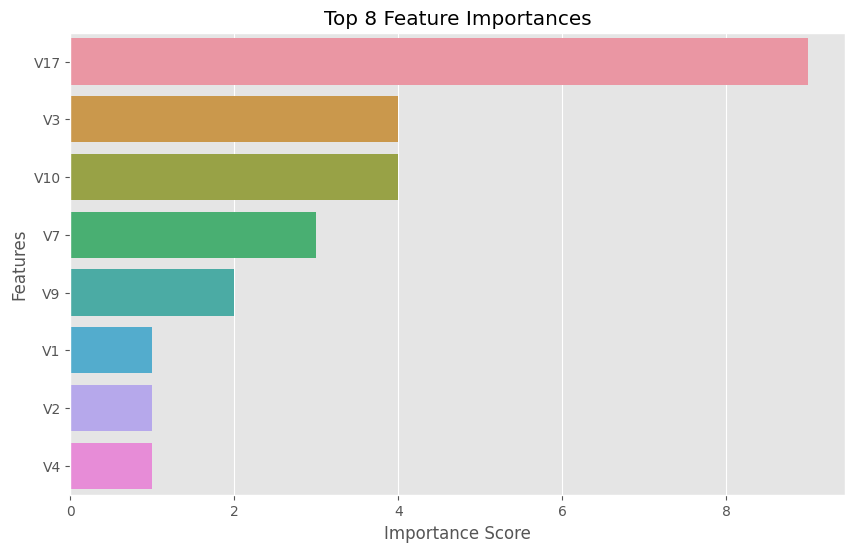

In [61]:
import seaborn as sns

# Add clustering results to the dataset
kmeans_labels = KMeans(n_clusters=2, random_state=0).fit_predict(train_no_label)
train['Cluster'] = kmeans_labels

# Feature importance analysis with XGBoost
dtrain = xgb.DMatrix(train[data_cols], label=train['Cluster'], feature_names=data_cols)
xgb_params = {
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc'
}
xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=10)

# Get feature importance
importance = xgb_model.get_score(importance_type='weight')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Select top N features for visualization
top_n = 8
top_features = sorted_importance[:top_n]
feature_names, scores = zip(*top_features)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=np.array(scores), y=np.array(feature_names))
plt.title('Top {} Feature Importances'.format(top_n))
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.optimizers import Adam
import os

In [63]:
# Add KMeans generated classes to fraud data - see classification section for more details on this

import sklearn.cluster as cluster

train = data.loc[ data['Class']==1 ].copy()

algorithm = cluster.KMeans
args, kwds = (), {'n_clusters':2, 'random_state':0}
labels = algorithm(*args, **kwds).fit_predict(train[ data_cols ])

print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )

fraud_w_classes = train.copy()
fraud_w_classes['Class'] = labels

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


   count
0    357
1    135


In [64]:
# Assuming 'fraud_w_classes' is the DataFrame from the classification part
# Normalizing the data as done in the classification section
label_cols = [col for col in fraud_w_classes.columns if 'Class' in col]
data_cols = [col for col in fraud_w_classes.columns if col not in label_cols]
fraud_w_classes[data_cols] = fraud_w_classes[data_cols] / 10

In [65]:
from keras.layers import Input
from keras.models import Model

# GAN Parameters
rand_dim = 32
base_n_count = 128
learning_rate = 5e-4
batch_size = 128
nb_steps = 500 + 1
log_interval = 100

# Define GAN Models (Placeholder for your actual GAN implementation)
def build_generator(rand_dim, data_dim):
    model = Sequential()
    model.add(Dense(base_n_count, input_dim=rand_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(data_dim, activation='tanh'))
    return model

def build_discriminator(data_dim):
    model = Sequential()
    model.add(Dense(base_n_count, input_dim=data_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Build and compile the discriminator
data_dim = len(data_cols)
discriminator = build_discriminator(data_dim)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate), metrics=['accuracy'])

# Build the generator
generator = build_generator(rand_dim, data_dim)

# The generator takes noise as input and generates data
z = Input(shape=(rand_dim,))
generated_data = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated data as input and determines validity
validity = discriminator(generated_data)

# The combined model (stacked generator and discriminator)
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate))

In [66]:
for step in range(nb_steps):
    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random batch of real data
    idx = np.random.randint(0, train_no_label.shape[0], batch_size)
    real_data = train_no_label.iloc[idx]

    # Generate a batch of new data (fake data)
    noise = np.random.normal(0, 1, (batch_size, rand_dim))
    gen_data = generator.predict(noise)

    # Train the discriminator (real classified as ones and generated as zeros)
    d_loss_real = discriminator.train_on_batch(real_data, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_data, np.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------

    # Train the generator (wants discriminator to mistake images as real)
    noise = np.random.normal(0, 1, (batch_size, rand_dim))
    valid_y = np.array([1] * batch_size)  # Generator wants discriminator to think these are real
    g_loss = combined.train_on_batch(noise, valid_y)

    # If at save interval => plot the progress
    if step % log_interval == 0:
        print(f"{step} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}] [G loss: {g_loss}]")

# Save models and weights as needed
generator.save('generator_model.h5')
discriminator.save('discriminator_model.h5')

4/4 [==============================] - 0s 3ms/step
0 [D loss: 0.8028059601783752, acc.: 37.890625] [G loss: 0.6021877527236938]
4/4 [==============================] - 0s 3ms/step
100 [D loss: 0.34644119441509247, acc.: 89.453125] [G loss: 0.924376368522644]
4/4 [==============================] - 0s 3ms/step
200 [D loss: 0.2996947020292282, acc.: 94.921875] [G loss: 1.1568551063537598]
4/4 [==============================] - 0s 3ms/step
300 [D loss: 0.2835802137851715, acc.: 92.96875] [G loss: 1.3154770135879517]
4/4 [==============================] - 0s 2ms/step
400 [D loss: 0.29361720383167267, acc.: 90.625] [G loss: 1.5595414638519287]
4/4 [==============================] - 0s 2ms/step
500 [D loss: 0.19192612171173096, acc.: 95.3125] [G loss: 1.67425537109375]


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 2ms/step


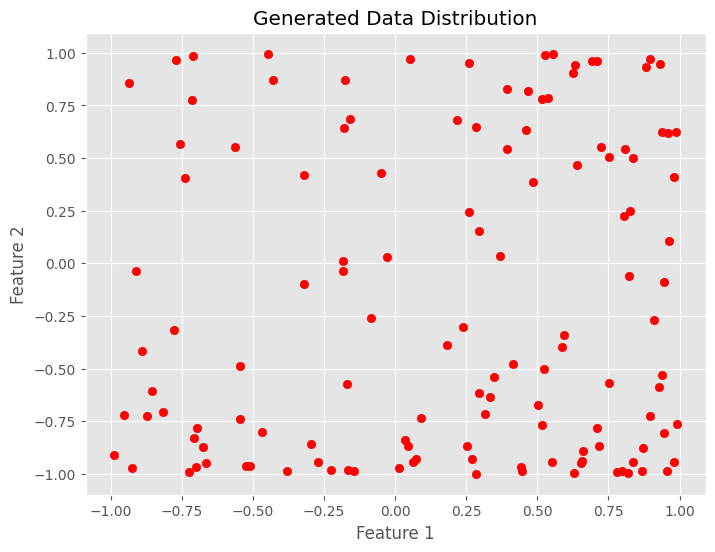

In [67]:
# Example of generating data
noise = np.random.normal(0, 1, (batch_size, rand_dim))
g_z = generator.predict(noise)

# Plotting generated data (customize as needed)
plt.figure(figsize=(8, 6))
plt.scatter(gen_data[:, 0], gen_data[:, 1], c='r')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Generated Data Distribution')
plt.show()

The plot titled "Generated Data Distribution" shows the spread of the generated data points in the feature space defined by 'Feature 1' and 'Feature 2'. The distribution of points can give insights into the generative model's performance, such as how well it has learned to mimic the structure of the training data (if it was trained on real data), or how diverse the generated samples are.

Generative models are often evaluated based on the quality and diversity of data they generate

Model Loading:

    It loads a pre-trained generator model from a saved file, generator_model.h5. This model is likely part of a Generative Adversarial Network (GAN) or a similar generative model.

Synthetic Data Generation:

    It generates a set of random noise vectors following a standard normal distribution, which serves as input to the generator model.
    The generator model predicts or generates synthetic data based on this noise.

Real Data Sampling:

    It samples a subset of real data from a DataFrame named fraud_w_classes for comparison with the synthetic data.

Plotting:

    A scatter plot is created to visually compare the real and generated data distributions in the feature space defined by 'Feature 1' and 'Feature 2'.
    The generated data is plotted in red, and the real data is plotted in blue, with both sets having a transparency level set by alpha=0.5 to visualize overlap.
    The plot includes a legend to distinguish between the real and generated data, and it has a title and axis labels

4/4 [==============================] - 0s 2ms/step


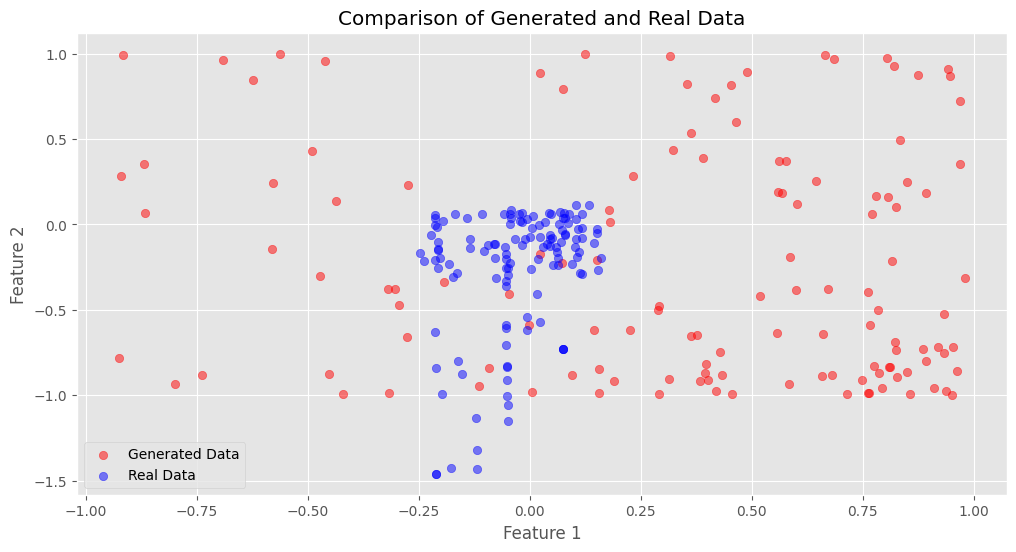

In [68]:
import matplotlib.pyplot as plt
import numpy as np

# Load your generator model (assuming it's already trained and saved)
from keras.models import load_model
generator = load_model('generator_model.h5')

# Generate fake data
noise = np.random.normal(0, 1, (batch_size, rand_dim))
gen_data = generator.predict(noise)

# Load or select real data for comparison
# Assuming 'fraud_w_classes' is your DataFrame and you've defined 'data_cols'
real_data = fraud_w_classes[data_cols].sample(n=batch_size).to_numpy()

# Plotting
plt.figure(figsize=(12, 6))

# Plot generated data
plt.scatter(gen_data[:, 0], gen_data[:, 1], color='red', alpha=0.5, label='Generated Data')

# Plot real data
plt.scatter(real_data[:, 0], real_data[:, 1], color='blue', alpha=0.5, label='Real Data')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Comparison of Generated and Real Data')
plt.legend()

plt.show()

    The generative model seems to have learned to some extent the central tendency of the real data but may not fully capture its distribution, especially regarding the spread along 'Feature 2'.
    There may be some overrepresentation of points within certain ranges of 'Feature 1' for the generated data, as indicated by the dense clustering in that region.
    The spread and density of the real data indicate variability and potential clusters that the generative model may not be replicating perfectly.